In [1]:
import argparse
import sys
import time
from pathlib import Path
from matplotlib import pyplot as plt
import numpy as np
import chess
import chess.svg
from svglib.svglib import svg2rlg
import cv2
import torch
import torch.backends.cudnn as cudnn

from models.experimental import attempt_load
from utils.datasets import LoadStreams, LoadImages
from utils.general import check_img_size, check_requirements, check_imshow, colorstr, non_max_suppression, \
    apply_classifier, scale_coords, xyxy2xywh, strip_optimizer, set_logging, increment_path, save_one_box
from utils.plots import colors, plot_one_box
from utils.torch_utils import select_device, load_classifier, time_synchronized
%matplotlib inline

ModuleNotFoundError: No module named 'models'

In [4]:
imgsz = 640
# source = "../chess_project/images"
source = "../chess_project/data/test/images/0b47311f426ff926578c9d738d683e76_jpg.rf.40183eae584a653181bbd795ba3c353f.jpg"
augment = False
classify = False
save_txt=True
save_conf=True
save_crop=True
project='runs/detect'
name="exp"
exist_ok=False
view_img = False
save_img = True
half=True
conf_thres=0.25  # confidence threshold
iou_thres=0.45  # NMS IOU threshold
max_det=1000  # maximum detections per image
classes = None # For filtering a specific class
agnostic_nms=False  # class-agnostic NMS
hide_labels=False  # hide labels
hide_conf=False  # hide confidences
line_thickness=3  # bounding box thickness (pixels)
update = False
FEN_mapping = {0:'b', 1:'k', 2:'n', 3:'p', 4:'q', 5:'r', 7:'B', 8:'K', 9:'N', 10:'P', 11:'Q', 12:'R'}

In [5]:
device='0'
batch_size = 32
device = select_device(device, batch_size=batch_size)
save_dir = increment_path(Path(project) / name, exist_ok=exist_ok)  # increment run
(save_dir / 'labels' if save_txt else save_dir).mkdir(parents=True, exist_ok=True)  # make dir

### Get the model, used for two models  
1. Chess board  
2. Chess pieces

In [6]:
def load_chess_yolov5_model(weights, imgsz):
    model = attempt_load(weights, map_location=device)  # load FP32 model
    gs = max(int(model.stride.max()), 32)  # grid size (max stride)
    imgsz = check_img_size(imgsz, s=gs)  # check image size
    stride = int(model.stride.max())  # model stride
    names = model.module.names if hasattr(model, 'module') else model.names  # get class names
    model.half()  # to FP16
    print(imgsz, gs)
    return model, stride, names

In [7]:
# names

### Define method to get Object coordinates based on model and image

In [8]:
def get_cordinates(dataset, model):
    t0 = time.time()
    for path, img, im0s, vid_cap in dataset:
        img = torch.from_numpy(img).to(device)
        img = img.half() if half else img.float()  # uint8 to fp16/32
        img /= 255.0  # 0 - 255 to 0.0 - 1.0
        if img.ndimension() == 3:
            img = img.unsqueeze(0)

        # Inference
        t1 = time_synchronized()
        pred = model(img, augment=augment)[0]
        # Apply NMS
        pred = non_max_suppression(pred, conf_thres, iou_thres, classes, agnostic_nms, max_det=max_det)
        t2 = time_synchronized()

        # Apply Classifier
        if classify:
            pred = apply_classifier(pred, modelc, img, im0s)

        # Process detections
        for i, det in enumerate(pred):  # detections per image
            p, s, im0, frame = path, '', im0s.copy(), getattr(dataset, 'frame', 0)

            p = Path(p)  # to Path
            save_path = str(save_dir / p.name)  # img.jpg
            txt_path = str(save_dir / 'labels' / p.stem) + ('' if dataset.mode == 'image' else f'_{frame}')  # img.txt
            s += '%gx%g ' % img.shape[2:]  # print string
            gn = torch.tensor(im0.shape)[[1, 0, 1, 0]]  # normalization gain whwh
            imc = im0.copy() if save_crop else im0  # for save_crop
#             print("detections: ", det)
#             print("detections-4: ", det[:,:4])

            if len(det):
                # Rescale boxes from img_size to im0 size
                det[:, :4] = scale_coords(img.shape[2:], det[:, :4], im0.shape).round()
#                 print("After change detections-4: ", det[:,:4])

                # Print results
                for c in det[:, -1].unique():
                    n = (det[:, -1] == c).sum()  # detections per class
                    s += f"{n} {names[int(c)]}{'s' * (n > 1)}, "  # add to string

                # Write results
                for *xyxy, conf, cls in reversed(det):
                    if save_txt:  # Write to file
                        xywh = (xyxy2xywh(torch.tensor(xyxy).view(1, 4)) / gn).view(-1).tolist()  # normalized xywh
                        line = (cls, *xywh, conf) if save_conf else (cls, *xywh)  # label format
                        with open(txt_path + '.txt', 'a') as f:
                            f.write(('%g ' * len(line)).rstrip() % line + '\n')

                    if save_img or save_crop or view_img:  # Add bbox to image
                        c = int(cls)  # integer class
                        label = None if hide_labels else (names[c] if hide_conf else f'{names[c]} {conf:.2f}')
                        plot_one_box(xyxy, im0, label=label, color=colors(c, True), line_thickness=line_thickness)
                        if save_crop:
                            save_one_box(xyxy, imc, file=save_dir / 'crops' / names[c] / f'{p.stem}.jpg', BGR=True)

            # Print time (inference + NMS)
#             print(f'{s}Done. ({t2 - t1:.3f}s)')

            # Stream results
            if view_img:
                plt.imshow(im0)
    #             cv2.waitKey(1)  # 1 millisecond

            # Save results (image with detections)
            if save_img:
                if dataset.mode == 'image':
                    cv2.imwrite(save_path, im0)
                else:  # 'video' or 'stream'
                    if vid_path != save_path:  # new video
                        vid_path = save_path
                        if isinstance(vid_writer, cv2.VideoWriter):
                            vid_writer.release()  # release previous video writer
                        if vid_cap:  # video
                            fps = vid_cap.get(cv2.CAP_PROP_FPS)
                            w = int(vid_cap.get(cv2.CAP_PROP_FRAME_WIDTH))
                            h = int(vid_cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
                        else:  # stream
                            fps, w, h = 30, im0.shape[1], im0.shape[0]
                            save_path += '.mp4'
                        vid_writer = cv2.VideoWriter(save_path, cv2.VideoWriter_fourcc(*'mp4v'), fps, (w, h))
                    vid_writer.write(im0)

    if save_txt or save_img:
        s = f"\n{len(list(save_dir.glob('labels/*.txt')))} labels saved to {save_dir / 'labels'}" if save_txt else ''
#         print(f"Results saved to {save_dir}{s}")

    if update:
        strip_optimizer(weights)  # update model (to fix SourceChangeWarning)

    print(f'Done. ({time.time() - t0:.3f}s)')
    return(det)


In [9]:
# img.shape, im0.shape

### Chess board Model

#### Load chessboard model

In [10]:
# board_weights = "../chess_project/model/chess_board.pt"
# board_model, stride, names = load_chess_yolov5_model(board_weights,imgsz)
# board_model(torch.zeros(1, 3, imgsz, imgsz).to(device).type_as(next(board_model.parameters())))
# print("model intiated")

# inboard_weights = "../chess_project/model/inboard.pt"
# inboard_model, stride, names = load_chess_yolov5_model(inboard_weights,imgsz)
# inboard_model(torch.zeros(1, 3, imgsz, imgsz).to(device).type_as(next(board_model.parameters())))
# print(" inboard model intiated")

#### Load Chess pieces model

In [11]:
chesspieces_weights = "../chess_project/model/chess_tuned_v1.pt"
# chesspieces_weights = "../chess_project/model/chess_tuned_v0.pt"
chesspieces_model, stride, names = load_chess_yolov5_model(chesspieces_weights,imgsz)
chesspieces_model(torch.zeros(1, 3, imgsz, imgsz).to(device).type_as(next(chesspieces_model.parameters())))
print("model intiated")

640 32
model intiated


In [12]:
# This is needed to reverse order of rank, needed for FEN Conversion
rank_reverse_mapping = {1:8,2:7,3:6,4:5,5:4,6:3,7:2,8:1}

def get_board_n_chesspiece_coords (dataset, chesspieces_model, imgsz,board_width=1000):
#     board_det = get_cordinates(dataset, board_model).squeeze().detach().cpu().numpy()
#     inboard_det = get_cordinates(dataset, inboard_model).squeeze().detach().cpu().numpy()
    inboard_class = 14
    outboard_class = 13
    chesspieces_det = get_cordinates(dataset, chesspieces_model).squeeze().detach().cpu().numpy()
    
    for piece in chesspieces_det:
        if int(piece[5]) == outboard_class:
            board_det = piece
        elif int(piece[5]) == inboard_class:
            inboard_det = piece
    
#   Changing from trapezoid to square using inboard and outboard positions
    pts1 = np.float32([[inboard_det[0],inboard_det[1]],[inboard_det[2],inboard_det[1]],[board_det[2],board_det[3]],[board_det[0],board_det[3]]])
    pts2 = np.float32([[0,0],[board_width,0],[board_width,board_width],[0,board_width]])

#   transformation matrix for converting to square
    M = cv2.getPerspectiveTransform(pts1,pts2)


    cell_width =  board_width/8
    cell_height = board_width/8
    piece_adjust = 1
    
    chesspieces_pos = []
    print("outer board pos", board_det)
    print("inner board pos", inboard_det)
#     print("square board is: ", board_new)
    print("chess piece pos", chesspieces_det)

    for piece in chesspieces_det:
        piece_class = int(piece[5])
        if piece_class not in (13,14):
#             print(cell_width, cell_height, piece)

            piece_class_name = names[piece_class]
            piece_class_prob = piece[4]
    #       chesspieces_pos.append([np.floor((piece[2] -board_left )/cell_width), np.floor((piece[3]-board_top)/cell_height), piece_class, piece_class_name, piece_class_prob ])
            transformed_cell = np.dot(M, [(piece[0]+piece[2])/2,(piece[1]+3*piece[3])/4,1])
            piece_x = np.min([transformed_cell[0]/transformed_cell[2],board_width])
            piece_y = np.min([transformed_cell[1]/transformed_cell[2],board_width]) 
            
#             if piece_y > 700 and piece_y < 800: 
#                 piece_y = piece_y - ( ( 5 * board_width - piece_y)/100)

            print("piece position: ", piece[0], ":", piece[2], ":", piece[1], ":", piece[3], " class: ", piece_class_name)
            print("transformed piece position: ", piece_x, ":", piece_y,  " class: ", piece_class_name)
            
            chesspieces_pos.append([np.ceil(piece_x/cell_width), rank_reverse_mapping.get(np.ceil(piece_y/cell_height)), piece_class, piece_class_name, piece_class_prob ])

    return chesspieces_pos

def convert_to_FEN(chess_positions, threshold=0.5):
    chess_pos_array = np.array(chess_positions)
#     add chess_pos_array[:,4]) for sorting on probability
    sorted_chess_pos = chess_pos_array[np.lexsort((chess_pos_array[:,1], chess_pos_array[:,0] ))]
    FENString = ""
    rank=1
    file=1
    prev_rank = 0
    prev_file = 1
    ctr=1
    print('sorted Chess positions: \n', sorted_chess_pos)
    
   
    for row in sorted_chess_pos:
        file = int(float(row[0]))
        rank = int(float(row[1]))
        prob = float(row[4])
        ch_class = int(float(row[2]))
        if rank <= 0: rank = 1
        if file <=0: file = 1
        print ( 'file:', file, 'rank:', rank, 'prev_file:', prev_file, 'prev_rank:', prev_rank,  'class:', FEN_mapping.get(int(float(row[2]))))
        if prob > threshold and ch_class != 6 and ch_class < 13 and file <= 8 and rank <=8 :
            if ( (ctr > 1)  and (prev_rank == rank) and (prev_file == file)):
                print("duplicate")
            else:
                if (  (file ==prev_file) and (rank > (prev_rank + 1))):
                    FENString = FENString + str(rank-(prev_rank + 1))
                if (file > prev_file):
#                   to cover left over spots in the old row
                    if prev_rank < 8:
                        FENString = FENString + str(8-prev_rank)
                    prev_rank = 0
                    if prev_file != 8:  
                        FENString = FENString + "/"
                    
                    
    #               if complete row is missing    
                    for gr in range(prev_file +1, file):
                        FENString = FENString + "8"
                        if gr != 8: 
                            FENString = FENString + "/"

#                   to cover empty spots in the new row
                    if ( rank > 1):
                        FENString = FENString + str(rank - 1)

                FEN_value = FEN_mapping.get(ch_class)

                if(FENString is None):
                    print("Non object - FENString")
                if(FEN_value is None):
                    print("Non object - get FEN ")

                FENString = FENString + FEN_value
                prev_rank = rank
                prev_file = file
        ctr += 1      
#     For any gaps left
    if prev_rank < 8:
        FENString = FENString + str(8-prev_rank)
    if prev_file != 8:
        FENString = FENString + "/"

#               if complete row is missing    
    for gr in range(prev_file +1, 9):
        FENString = FENString + "8"
        if gr != 8: 
            FENString = FENString + "/"


    return FENString



In [13]:
def fen_to_image(fen):
    board = chess.Board(fen)
    current_board = chess.svg.board(board=board)

    output_file = open('current_board.svg', "w")
    output_file.write(current_board)
    output_file.close()

    svg = svg2rlg('current_board.svg')
    renderPM.drawToFile(svg, 'current_board.png', fmt="PNG")
    return board

In [313]:
source = "../chess_project/data/test/images/0b47311f426ff926578c9d738d683e76_jpg.rf.40183eae584a653181bbd795ba3c353f.jpg"
# source = "../chess_project/data/test/images/IMG_0159_JPG.rf.f0d34122f8817d538e396b04f2b70d33.jpg"
# source = "../chess_project/data/test/images/2021_07_11_04_58_37_PMframe177.jpeg"
# source = "../chess_project/data/test/images/2021_07_11_04_50_57_PMframe157.jpeg" 

dataset = LoadImages(source, img_size=imgsz, stride=stride)
chess_pos = get_board_n_chesspiece_coords(dataset,  chesspieces_model, imgsz)
# chess_pos

image 1/1 C:\prabhu\edu\code\w251\myrepo\yolov5\..\chess_project\data\test\images\0b47311f426ff926578c9d738d683e76_jpg.rf.40183eae584a653181bbd795ba3c353f.jpg: Done. (0.110s)
outer board pos [         14           6         406         400     0.89697          13]
inner board pos [         52          17         341         397     0.52832          14]
chess piece pos [[         14           6         406         400     0.89697          13]
 [        202           6         224          63     0.85547           7]
 [         52          17         341         397     0.52832          14]]
piece position:  202.0 : 224.0 : 6.0 : 63.0  class:  white-bishop
transformed piece position:  551.6937272529831 : 109.2163947445204  class:  white-bishop


In [314]:
# source = "../chess_project/data/test/images/"
# dataset = LoadImages(source, img_size=imgsz, stride=stride)
# chess_pos = get_board_n_chesspiece_coords(dataset, board_model, chesspieces_model, imgsz)
# # chess_pos

### Chess Lables  
bishop - 0  
black-bishop - 1  
black-king -2  
black-knight - 3  
black-pawn - 4  
black-queen - 5  
black-rook -6  
white-bishop -7  
white-king -8  
white-knight -9  
white-pawn -10  
white-queen -11  
white-rook - 12  

In [315]:
# FEN_mapping.get(0)
FEN_string = convert_to_FEN(chess_pos)
FEN_string
# chess_pos_array = np.array(chess_pos)
# # chess_pos_array[chess_pos_array[:,0].argsort()]
# chess_pos_array[np.lexsort((chess_pos_array[:,1], chess_pos_array[:,0]))]

sorted Chess positions: 
 [['5.0' '8' '7' 'white-bishop' '0.85546875']]
file: 5 rank: 8 prev_file: 1 prev_rank: 0 class: B


'8/8/8/8/7B/8/8/8'

In [15]:
from reportlab.graphics import renderPM
import chess
import chess.svg
from svglib.svglib import svg2rlg
from reportlab.graphics import renderPM
from PIL import Image
import re
import glob
import PIL
blank = '8/8/8/8/8/8/8/8'
# FEN_string = 'rnbqk1nr/pppppppp/8/2b5/8/8/PPPPPPPP/RNBQKBNR'
board = fen_to_image(FEN_string)
board_image = cv2.imread('current_board.png')


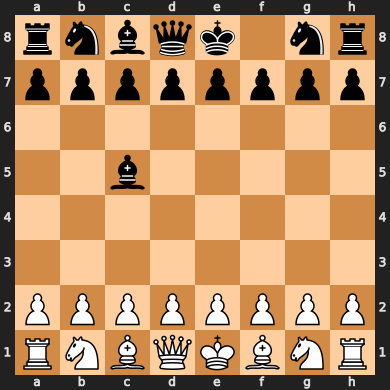

In [16]:
%matplotlib inline
board

(945.8457937849431, 903.1010271746194) 12
(171.97735374292296, 412.4260851331516) 2
(433.72452620727915, 531.5359606692571) 10
(193.75219504981607, 670.8867077025454) 3
(577.8660155005838, 384.86251194394305) 10
(828.5611557821795, 893.7046479701904) 10
(811.6010725715767, 794.1890839892741) 10
(207.66568554516934, 911.4694181194811) 3
(815.2852913021214, 277.84011220196334) 10
(194.197498921949, 799.4670116429496) 3
(804.8081483885462, -3.3027935192353484) 10
(691.0716289508134, 648.2625771460632) 9
(447.736864435165, 270.80588616215965) 3
(409.55729984301405, 416.3076923076923) 3
(319.03007859436235, 544.6589319833748) 3
(943.8094835243855, 393.60010151854806) 9
(943.0860194545106, 113.55140186915851) 8
(809.333270419478, 139.41867597791702) 10
(303.7258389659669, 126.55282817502666) 3
(177.64190410178966, 18.558308785305744) 3
(565.399372166027, 684.0912011455216) 10
(34.54974068835443, 141.38613861386142) 5
(954.2261398720302, 266.3877578415139) 12
(682.8870088840828, 388.047834107

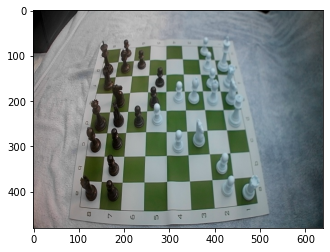

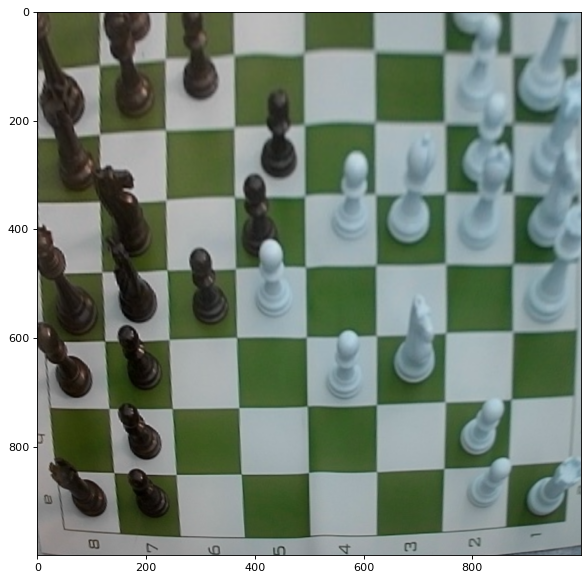

<Figure size 640x640 with 0 Axes>

In [253]:
# import cv2 as cv
# import matplotlib.pyplot as plt
# import numpy as np


# img = cv.imread("../chess_project/data/test/images/2021_07_11_04_58_37_PMframe177.jpeg") #7 or 13
# rows,cols,ch = img.shape

# boarddet = [75, 68, 516, 461, 0.85596, 13]
# inboarddet = [161, 91, 432, 467, 0.48218, 14]
# piecedet = [[459, 361, 503, 421, 0.89844, 12],
#  [173, 162, 208, 216, 0.89453, 2],
#  [260, 204, 287, 256, 0.89062, 10],
#  [170, 260, 198, 309, 0.88818, 3],
#  [308, 154, 334, 207, 0.88184, 10],
#  [414, 362, 449, 414, 0.88086, 10],
#  [402, 313, 433, 364, 0.87646, 10],
#  [158, 373, 189, 423, 0.87451, 3],
#  [379, 125, 405, 174, 0.87354, 10],
#  [161, 317, 191, 366, 0.87256, 3],
#  [368, 58, 390, 101, 0.86621, 10],
#  [350, 235, 380, 305, 0.86475, 9],
#  [269, 126, 292, 171, 0.86426, 3],
#  [255, 167, 279, 216, 0.86133, 3],
#  [221, 208, 247, 261, 0.85889, 3],
#  [423, 150, 453, 212, 0.85352, 9],
#  [406, 55, 438, 139, 0.84961, 8],
#  [373, 90, 397, 136, 0.83691, 10],
#  [230, 86, 251, 133,  0.7876, 3],
#  [198, 63, 219, 106, 0.78662, 3],
#  [306, 261, 334, 316, 0.76904, 10],
#  [147, 68, 179, 144, 0.75, 5],
#  [419, 118, 448, 172, 0.74658, 12],
#  [341, 146, 368, 211, 0.74365, 7],
#  [430, 182, 466, 260, 0.73633, 11],
#  [117, 257, 151, 314, 0.73438, 1],
#  [102, 363, 143, 423, 0.71094, 5],
#  [383, 152, 413, 212,  0.6665, 10],
#  [129, 194, 161, 266, 0.65234, 1],
#  [174, 202, 201, 259, 0.61816, 3],
#  [126, 193, 163, 268, 0.51855, 5],
#  [420, 119, 449, 173, 0.49463, 9],
#  [102, 364, 143, 423,  0.3894, 1],
#  [192, 87, 217, 141, 0.36426, 5],
#  [101, 359, 143, 423, 0.29004, 3],
#  [150, 122, 179, 180, 0.27295, 2],
#  [384, 152, 414, 211, 0.26978, 7],
#  [149, 122, 179, 179,  0.2561, 5]]

# pts1 = np.float32([[inboarddet[0],inboarddet[1]],[inboarddet[2],inboarddet[1]],[boarddet[2],boarddet[3]],[boarddet[0],boarddet[3]]])
# pts2 = np.float32([[0,0],[1000,0],[1000,1000],[0,1000]])

# M = cv.getPerspectiveTransform(pts1,pts2)
# dst = cv.warpPerspective(img,M,(1000,1000))

# plt.imshow(img),plt.figure(figsize=(12,9), dpi=80)
# plt.imshow(dst),plt.figure(figsize=(8,8), dpi=80)

# for p in piecedet:
#   v = np.dot(M, [(p[0]+p[2])/2,(p[1]+3*p[3])/4,1])
#   print((v[0]/v[2], v[1]/v[2]), p[-1])